In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import _pickle as pickle
import random

In [2]:
claims_path = "/Users/xxz005/Desktop/Raw_Data/PFK_Jan 2009 - Jul 2017/Claims.txt"
Eligibility_path = "/Users/xxz005/Desktop/RAW_DATA/PFK_Jan 2009 - Jul 2017/Eligibility.txt"
Rxclaims_path = "/Users/xxz005/Desktop/Raw_Data/PFK_Jan 2009 - Jul 2017/Rxclaims.txt"

In [3]:
def process(claims_path, year_list):
    pid_svcdt_map = {}
    svcdt_info_map = {}
    pid_dob_map = {}
    pid_gender_map = {}
    pid_zip_map = {}
    
    with open(claims_path) as infile:
        next(infile)
        for i,line in enumerate(infile):
            line=line.split("|")
            
            # Temporal
            svcdt = line[27][:9]
            if svcdt[-4:] not in year_list:continue
            svcenddt = line[28][:9]
            
            # claim 
            pid = line[0]
            claimtype = line[71]            
            
            # Medical
            diag1 = line[13] #diag1~3 only 
            diag2 = line[14]
            diag3 = line[15]
            proc = line[21]
            GrouperDRG = line[63]
            APR_DRG = line[131]
            
            # Utilization
            payorid = line[3]
            PCPID = line[4]
            provid = line[36]
            majcat = line[39]
            eradmit = line[50]
            submit = line[44]
            paid = line[46]
            
            svcdt_pid = svcdt+"||"+pid
            info = [svcdt, svcenddt,                                                     # temporal
                    diag1, diag2, diag3, proc, GrouperDRG, APR_DRG,                      # medical
                    claimtype, payorid, PCPID, provid, majcat, eradmit, submit, paid]    # utilization
            
            if pid not in pid_svcdt_map:
                pid_svcdt_map[pid] = set([svcdt_pid])
            else:
                pid_svcdt_map[pid].add(svcdt_pid)
                
            if svcdt_pid not in svcdt_info_map:
                svcdt_info_map[svcdt_pid] = [info]
            else:
                svcdt_info_map[svcdt_pid].append(info)  
            
            # Demographic
            if len(line[51])<4:continue
            
            dob=line[51][:9]
            gender = line[10]
            Zip = line[5]
            Age = line[9]
            
            if pid not in pid_dob_map: 
                pid_dob_map[pid] = [dob]
            else:
                pid_dob_map[pid].append(dob)
            
            if pid not in pid_gender_map: 
                pid_gender_map[pid] = [gender]
            else:
                pid_gender_map[pid].append(gender)
            
            if pid not in pid_zip_map: 
                pid_zip_map[pid] = [Zip]
            else:
                pid_zip_map[pid].append(Zip)
                
    return pid_svcdt_map, svcdt_info_map, pid_dob_map, pid_gender_map, pid_zip_map

In [4]:
startTime = datetime.now()

pid_svcdt_map, svcdt_info_map, pid_dob_map, pid_gender_map, pid_zip_map = process(claims_path, ["2011", "2012", "2013", "2014"])

print(datetime.now() - startTime)

0:22:26.941115


In [5]:
len(pid_svcdt_map), len(svcdt_info_map)


(448739, 8545241)

In [6]:
def processRX(claims_path, year_list):
    pid_svcdt_map = {}
    svcdt_info_map = {}
    
    with open(claims_path) as infile:
        next(infile)
        for i,line in enumerate(infile):
            line=line.split("|")
            
            # Temporal
            svcdt = line[7][:9]
            if svcdt[-4:] not in year_list:continue
            
            # claim 
            pid = line[0]
            claimtype = "RX"          
            
            # Medical
            NDC = line[12] 
            Drugname = line[13]
            DrugClass = line[16]
            
            # Utilization
            Supply = "Supply_"+ str(line[8])
            Pharmname = line[23]
            payorid = line[2]
            paid = line[19]
            
            svcdt_pid = svcdt+"||"+pid
            info = [svcdt,                                         # temporal
                    NDC, Drugname, DrugClass,                      # medical
                    Supply, Pharmname, payorid, paid]              # utilization
            
            if pid not in pid_svcdt_map:
                pid_svcdt_map[pid] = set([svcdt_pid])
            else:
                pid_svcdt_map[pid].add(svcdt_pid)
                
            if svcdt_pid not in svcdt_info_map:
                svcdt_info_map[svcdt_pid] = [info]
            else:
                svcdt_info_map[svcdt_pid].append(info)  
            
    return pid_svcdt_map, svcdt_info_map

In [7]:
startTime = datetime.now()

pid_svcdt_map_RX, svcdt_info_map_RX = processRX(Rxclaims_path, ["2011", "2012", "2013", "2014"])

print(datetime.now() - startTime)

0:16:59.046489


In [8]:
def eli_extract(path):
    pid_eli_map = {}
    with open(path) as infile:
        next(infile)
        for line in infile:
            line = line.split('|')
            pid = line[0]
            eli_month = line[1]
            if pid not in pid_eli_map:
                pid_eli_map[pid] = [eli_month]
            else:
                pid_eli_map[pid].append(eli_month)
    return pid_eli_map

def check_eli(pid_eli_map, year_list):
    pid_list = []
    for p in pid_eli_map:
        eli_flag=1
        for year in year_list:
            months = [i for i in pid_eli_map[p] if i.startswith(year)]
            if len(months) !=12:
                eli_flag=0
                break
        if eli_flag: pid_list.append(p)
    return pid_list

def age_flag(p, age, year):
    if p not in pid_dob_map:
        return 0
    else:
        return int(pid_dob_map[p][0][-4:]) < year-age

In [9]:
startTime = datetime.now()

pid_eli_map = eli_extract(Eligibility_path)
pid_list = check_eli(pid_eli_map, ["2011", "2012", "2013", "2014"])
pid_list = [p for p in pid_list if age_flag(p, 2, 2011)]
print("# of eligible patients:", len(pid_list))

print(datetime.now() - startTime)

# of eligible patients: 82727
0:01:01.892075


In [10]:
startTime = datetime.now()
StartDay = datetime.strptime('01JAN2013', '%d%b%Y')


cost2011_seq = []
cost2012_seq = []
cost2013_seq = []
cost2014_seq = []


for i, pid in enumerate(pid_list):
    cost2011 = 0
    cost2012 = 0
    cost2013 = 0
    cost2014 = 0

    for claim in pid_svcdt_map[pid]:
        claim_cost = 0
        for line_trans in svcdt_info_map[claim]:
            claim_date = (datetime.strptime(line_trans[0], '%d%b%Y') - StartDay).days
            claim_cost += max(0, float(line_trans[15]))

        if line_trans[0][-4:]=="2011":
            cost2011 += claim_cost

        elif line_trans[0][-4:]=="2012": 
            cost2012+=claim_cost

        elif line_trans[0][-4:]=="2013": 
            cost2013+=claim_cost
        
        elif line_trans[0][-4:]=="2014": 
            cost2014+=claim_cost            
            
    if pid in pid_svcdt_map_RX:
        for claim in pid_svcdt_map_RX[pid]:
            claim_cost = 0
            for line_trans in svcdt_info_map_RX[claim]:
                claim_date = (datetime.strptime(line_trans[0], '%d%b%Y') - StartDay).days
                claim_cost += max(0, float(line_trans[7]))

            if line_trans[0][-4:]=="2011":
                cost2011+=claim_cost

            elif line_trans[0][-4:]=="2012": 
                cost2012+=claim_cost

            elif line_trans[0][-4:]=="2013": 
                cost2013+=claim_cost
        
            elif line_trans[0][-4:]=="2014": 
                cost2014+=claim_cost 
                
    cost2011_seq.append(cost2011)
    cost2012_seq.append(cost2012)
    cost2013_seq.append(cost2013)
    cost2014_seq.append(cost2014)

print(datetime.now() - startTime)

0:02:59.649187


In [11]:
startTime = datetime.now()

pickle.dump(cost2011_seq,open("temporal/cost2011_seq","wb"))
pickle.dump(cost2012_seq,open("temporal/cost2012_seq","wb"))
pickle.dump(cost2013_seq,open("temporal/cost2013_seq","wb"))
pickle.dump(cost2014_seq,open("temporal/cost2014_seq","wb"))

print(datetime.now() - startTime)

0:00:00.330266


In [2]:
# startTime = datetime.now()

# cost2011 = pickle.load(open("temporal/cost2011","rb"))
# cost2012 = pickle.load(open("temporal/cost2012","rb"))
# cost2013 = pickle.load(open("temporal/cost2013","rb"))
# cost2014 = pickle.load(open("temporal/cost2014","rb"))

# print(datetime.now() - startTime)

0:00:00.007916


In [14]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [15]:
rank_2011 = np.array([x/len(cost2011_seq) for x in ss.rankdata(cost2011_seq)])
rank_2012 = np.array([x/len(cost2012_seq) for x in ss.rankdata(cost2012_seq)])
rank_2013 = np.array([x/len(cost2013_seq) for x in ss.rankdata(cost2013_seq)])
rank_2014 = np.array([x/len(cost2014_seq) for x in ss.rankdata(cost2014_seq)])

In [17]:
for i in [rank_2011, rank_2012, rank_2013, rank_2014]:
    print()
    for j in [rank_2011, rank_2012, rank_2013, rank_2014]:
        print(scipy.stats.pearsonr(i, j)[0])


0.9999999999999978
0.5165065053059802
0.442744605469663
0.3906257245490618

0.5165065053059802
1.0
0.5503545822288975
0.48028797084133446

0.442744605469663
0.5503545822288975
0.9999999999999973
0.5738705807936492

0.3906257245490618
0.48028797084133446
0.5738705807936492
1.0


In [27]:
np.mean(rank_2011[idx]), np.mean(rank_2012[idx]), np.mean(rank_2013[idx]), np.mean(rank_2014[idx])

In [43]:
np.std(rank_2011[idx]), np.std(rank_2012[idx]), np.std(rank_2013[idx]), np.std(rank_2014[idx])

(0.008657426839964908,
 0.2675544750843733,
 0.283241514166482,
 0.28992580198662665)

In [45]:
len([x for x in rank_2012[idx] if x>0.97])/len(idx), \
len([x for x in rank_2013[idx] if x>0.97])/len(idx), \
len([x for x in rank_2014[idx] if x>0.97])/len(idx)

(0.20314389359129384, 0.16968964127367997, 0.14631197097944376)

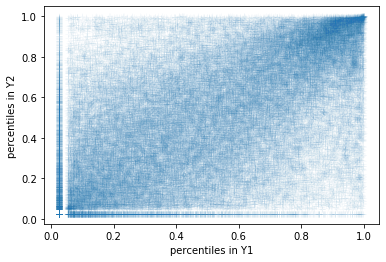

In [19]:
plt.plot(rank_2011, rank_2012, "+", alpha=0.03)
plt.ylabel('percentiles in Y2')
plt.xlabel('percentiles in Y1')
plt.show()

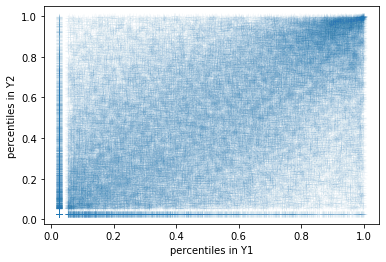

In [19]:
plt.plot(rank_2011, rank_2013, "+", alpha=0.03)
plt.ylabel('percentiles in Y2')
plt.xlabel('percentiles in Y1')
plt.show()

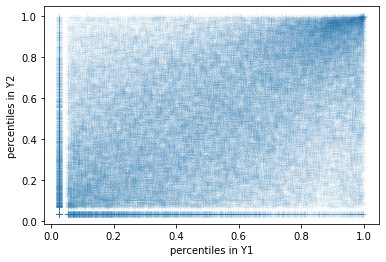

In [20]:
plt.plot(rank_2011, rank_2014, "+", alpha=0.03)
plt.ylabel('percentiles in Y2')
plt.xlabel('percentiles in Y1')
plt.show()

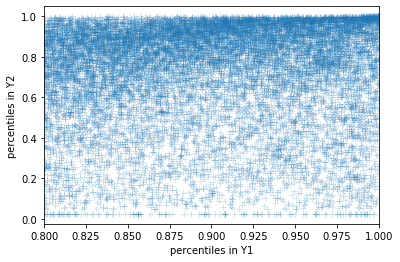

In [21]:
plt.plot(rank_2011, rank_2012, "+", alpha=0.2)
plt.ylabel('percentiles in Y2')
plt.xlabel('percentiles in Y1')
plt.xlim(0.8,1)
plt.show()

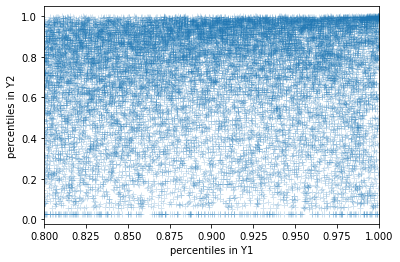

In [22]:
plt.plot(rank_2011, rank_2013, "+", alpha=0.2)
plt.ylabel('percentiles in Y2')
plt.xlabel('percentiles in Y1')
plt.xlim(0.8,1)
plt.show()

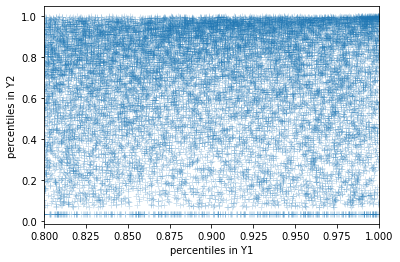

In [23]:
plt.plot(rank_2011, rank_2014, "+", alpha=0.2)
plt.ylabel('percentiles in Y2')
plt.xlabel('percentiles in Y1')
plt.xlim(0.8,1)
plt.show()

In [21]:
k=1
idx_2011 = np.argsort(rank_2011)[::-1][:len(rank_2011)//100 *k]
idx_2012 = np.argsort(rank_2012)[::-1][:len(rank_2012)//100 *k]
idx_2013 = np.argsort(rank_2013)[::-1][:len(rank_2013)//100 *k]
idx_2014 = np.argsort(rank_2014)[::-1][:len(rank_2014)//100 *k]

In [22]:
len(idx_2011), len(rank_2011)

(827, 82727)

In [23]:
len(set(idx_2011).intersection(idx_2012))/len(idx_2011)

0.1837968561064087

In [24]:
len(set(idx_2011).intersection(idx_2012).intersection(idx_2013))/len(idx_2011)

0.11366384522370013

In [25]:
len(set(idx_2011).intersection(idx_2012).intersection(idx_2013).intersection(idx_2014))/len(idx_2011)

0.0773881499395405

In [29]:
scipy.stats.pearsonr(rank_2011[idx_2011], rank_2012[idx_2011])

(0.11285508710144018, 0.0011503044507265507)